# Obligatory introduction to NN and Pytorch

In [ ]:
import torch

def activation(x):
    return 1/(1+torch.exp(-x))

torch.manual_seed(404)

# Generate some data
features = torch.randn((1, 5))
weights = torch.randn_like(features) # Inherit shape of features
bias = torch.randn((1, 1))

In [ ]:
# Calculating the output of the neuron
# Method 1: mm method of torch
# torch.mm(features, weights) # Error

In [ ]:
activation(torch.mm(features, weights.view(5, 1)) + bias)

tensor([[0.0506]])

This is by using the tensor.view(shape_tuple) method to reshape

In [ ]:
# or
activation(torch.mm(features, weights.reshape(5, 1)) + bias)

tensor([[0.0506]])

This is by using the reshape method. However, reshape clones it to new memory location. Use sparingly when spatial locality condition exists in code

Note that torch.matmul supports broadcasting and is not that strict with respect to shapes and tensor sizes

In [ ]:
activation(torch.matmul(weights, features.t()) + bias) # tensor.t() does transpose

tensor([[0.0506]])

## Stacking some layers

In [ ]:
features = torch.randn((1, 3))

n_input = features.shape[1]
n_hidden = 2
n_output = 1

W1 = torch.randn(n_input, n_hidden)
W2 = torch.randn(n_hidden, n_output)

b1 = torch.randn((1, n_hidden))
b2 = torch.randn((1, n_output))

In [ ]:
hidden_outputs = activation(torch.mm(features, W1) + b1)
output = activation(torch.mm(hidden_outputs, W2) + b2)
output

tensor([[0.9165]])

## Numpy and Torch interoperability

In [ ]:
import numpy as np
a = np.random.rand(4, 3) # This is from uniform dist, use randn for normal
a

array([[0.45769935, 0.87766961, 0.49479135],
       [0.53315174, 0.67289907, 0.79607852],
       [0.38952338, 0.02940523, 0.52759923],
       [0.8645661 , 0.12402806, 0.47848791]])

In [ ]:
b = torch.from_numpy(a)
type(b)

torch.Tensor

In [ ]:
b

tensor([[0.4577, 0.8777, 0.4948],
        [0.5332, 0.6729, 0.7961],
        [0.3895, 0.0294, 0.5276],
        [0.8646, 0.1240, 0.4785]], dtype=torch.float64)

In [ ]:
type(b.numpy())

numpy.ndarray

In [ ]:
# Scalar in-place mul of t.tensor
b.mul_(2)

tensor([[0.9154, 1.7553, 0.9896],
        [1.0663, 1.3458, 1.5922],
        [0.7790, 0.0588, 1.0552],
        [1.7291, 0.2481, 0.9570]], dtype=torch.float64)

In [ ]:
b # new values instead of old. ie In place operation

tensor([[0.9154, 1.7553, 0.9896],
        [1.0663, 1.3458, 1.5922],
        [0.7790, 0.0588, 1.0552],
        [1.7291, 0.2481, 0.9570]], dtype=torch.float64)

In [ ]:
a # a was numpy array and it also changed!

array([[0.91539869, 1.75533921, 0.98958271],
       [1.06630347, 1.34579814, 1.59215703],
       [0.77904676, 0.05881047, 1.05519846],
       [1.7291322 , 0.24805611, 0.95697582]])

In [ ]:
type(a) # type still remains ndarray though

numpy.ndarray

# NN in Pt

In [ ]:
# Import the holy trinity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import helper

In [ ]:
from torchvision import datasets, transforms

# Transforms are functions used to preprocess, eg: Normalization
# Compose() can combine multiple transforms together as list
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, ), std=(0.5, ))
                                ])

# Download training data and apply transforms
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [ ]:
# Create iterator on loader
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape) # 64 images of 1 color channel, 28x28 pixels
print(labels.shape) # 64 integer labels

torch.Size([64, 1, 28, 28])
torch.Size([64])


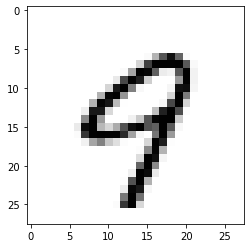

In [ ]:
plt.imshow(images[0][0].numpy(), cmap='Greys')

In [ ]:
# Reshaped view, preserving only the 64 indexes and flattening the rest with -1
images.view(images.shape[0], -1).shape

torch.Size([64, 784])

In [ ]:
len(images.view(images.shape[0], -1)[0]) # One of the images that is flattened into vector of len 784

784

In [ ]:
# Simple solution to classification

def activation(x):
    return 1 / (1 + torch.exp(-x))

# Flatten the images
inputs = images.view(images.shape[0], -1)

# Define weights and biases
# layer 1: 786 inputs to 256 neurons
W1 = torch.randn(len(inputs[0]), 256)
b1 = torch.randn(256)

# layer 2: 256 neurons to output of 10 softmax wrapped neurons
W2 = torch.randn(256, 10)
b2 = torch.randn(10)

# first layer out:
h = activation(torch.mm(inputs, W1) + b1)
# output layer out:
out = torch.mm(h, W2) + b2

# This needs to be wrapped with softmax activation
def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), dim=1).view(-1, 1)

probabilities = softmax(out)
probabilities.shape # should be 10 probabilities each for 64 of the inputs in the batch


torch.Size([64, 10])

## Building Networks with Pytorch

In [ ]:
from torch import nn

class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # inputs(784) to hidden (256 neurons)
        self.hidden = nn.Linear(in_features=784, out_features=256, bias=True)
        # output (previous 256) to output neurons (10)
        self.output = nn.Linear(in_features=256, out_features=10, bias=True)

        # Define Activations
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Pass x through each layer and activations
        # return self.softmax(self.output(self.sigmoid(self.hidden(x))))
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        return x

model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

Smarter, more concise way to do this

In [ ]:
import torch
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Define layers
        self.hidden = nn.Linear(in_features=784, out_features=256, bias=True)
        self.output = nn.Linear(in_features=256, out_features=10, bias=True)

    def forward(self, x):
        # Hidden with sigmoid
        x = F.sigmoid(self.hidden(x))
        # Output with softmax
        x = F.softmax(self.output(x), dim=1)
        return x

model = Network(); model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
import torch
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Define layers: (in:784) > 128 > 64> (out:10)
        self.hidden1 = nn.Linear(in_features=784, out_features=128, bias=True)
        self.hidden2 = nn.Linear(in_features=128, out_features=64, bias=True)
        self.output = nn.Linear(in_features=64, out_features=10, bias=True)

    def forward(self, x):
        x = self.hidden1(x)
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.output(x)
        x = F.softmax(x, dim=1)
        return x

model = Network(); model

Network(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
print(model.hidden1.weight) # Of type parameter, by default requires_grad=True

Parameter containing:
tensor([[-0.0065, -0.0083,  0.0281,  ...,  0.0252,  0.0302, -0.0324],
        [-0.0126, -0.0260, -0.0111,  ...,  0.0274, -0.0210,  0.0159],
        [ 0.0229,  0.0182,  0.0091,  ...,  0.0057, -0.0357, -0.0224],
        ...,
        [ 0.0126, -0.0056,  0.0148,  ..., -0.0135,  0.0205,  0.0038],
        [-0.0122, -0.0198,  0.0221,  ...,  0.0314,  0.0005,  0.0333],
        [ 0.0017, -0.0181, -0.0135,  ...,  0.0043, -0.0235,  0.0107]],
       requires_grad=True)


In [ ]:
model.hidden1.bias

Parameter containing:
tensor([-0.0252, -0.0226,  0.0179,  0.0189,  0.0160,  0.0292, -0.0280, -0.0141,
         0.0085, -0.0290,  0.0307,  0.0180, -0.0319, -0.0214,  0.0307, -0.0287,
         0.0031, -0.0281,  0.0166, -0.0276, -0.0076, -0.0277, -0.0002, -0.0235,
         0.0099,  0.0351, -0.0068,  0.0094,  0.0296, -0.0349,  0.0059, -0.0102,
        -0.0098, -0.0061,  0.0075, -0.0347, -0.0151, -0.0332,  0.0045, -0.0015,
        -0.0229,  0.0077,  0.0267, -0.0219, -0.0265, -0.0265,  0.0087, -0.0177,
         0.0180, -0.0039,  0.0198,  0.0335, -0.0209,  0.0234,  0.0209, -0.0246,
         0.0196, -0.0348, -0.0169, -0.0175,  0.0225,  0.0075,  0.0051,  0.0096,
         0.0087,  0.0062, -0.0303, -0.0211,  0.0340,  0.0353,  0.0108,  0.0258,
         0.0233,  0.0009,  0.0298,  0.0163, -0.0014,  0.0141,  0.0313, -0.0063,
         0.0227,  0.0339, -0.0019, -0.0176,  0.0330, -0.0147, -0.0282, -0.0324,
         0.0074, -0.0022,  0.0249,  0.0259,  0.0109,  0.0193,  0.0255,  0.0228,
        -0.0021,  

In [ ]:
# Weights Initialization
# Initialize all weights to Random Normal with standard deviation = 0.01
model.hidden1.weight.data.normal_(std=0.01)
model.hidden2.weight.data.normal_(std=0.01)
model.output.weight.data.normal_(std=0.01)
# Initialize bias to zero
model.hidden1.bias.data.fill_(0)
model.hidden2.bias.data.fill_(0)
model.output.bias.data.fill_(0);

In [ ]:
### CAUTION CYCLIC ###
# Make a data iterator
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [ ]:
images.shape # 64 images of 1 channel, 28x28 pixels

torch.Size([64, 1, 28, 28])

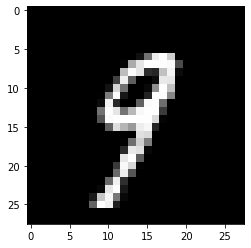

In [ ]:
plt.imshow(images[0][0], cmap='Greys_r')

In [ ]:
images.resize_(images.shape[0], 1, 28*28)

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.]],

        ...,

        [[-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.]]])

In [ ]:
images.shape # Note that resize_() is in-place

torch.Size([64, 1, 784])

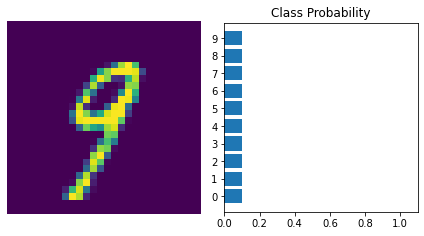

In [ ]:
# Credits to this function
# https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/helper.py
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()


img_idx = 0
probabilities = model.forward(images[img_idx, :]) #0th row, all 784 columns
img = images[img_idx]
view_classify(img.view(1, 28, 28), probabilities)

It is showing equal(ish) probabilities because all weights are initialized randomly

# Using nn.Sequential()

In [ ]:
# Defining HyperPs

input_size = 784
hidden_size = [128, 64]
output_size = 10

# Using nn.Sequential abstraction
model = nn.Sequential(
    nn.Linear(in_features=input_size, out_features=hidden_size[0], bias=True),
    nn.ReLU(),
    nn.Linear(in_features=hidden_size[0], out_features=hidden_size[1], bias=True),
    nn.ReLU(),
    nn.Linear(in_features=hidden_size[1], out_features=output_size, bias=True),
    nn.Softmax(dim=1)
)

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


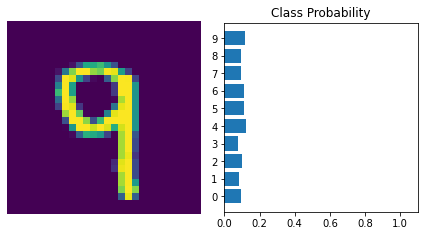

In [ ]:
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 28*28)
probs = model.forward(images[0, :])
view_classify(images[0].view(1, 28, 28), probs)

In [ ]:
model[0]

Linear(in_features=784, out_features=128, bias=True)

In [ ]:
model[0].weight

Parameter containing:
tensor([[ 0.0100,  0.0212,  0.0353,  ..., -0.0315,  0.0009, -0.0136],
        [-0.0005,  0.0070, -0.0336,  ..., -0.0158,  0.0146, -0.0031],
        [ 0.0297,  0.0093, -0.0009,  ..., -0.0286,  0.0047, -0.0011],
        ...,
        [-0.0302, -0.0125,  0.0189,  ...,  0.0140, -0.0169, -0.0124],
        [ 0.0266,  0.0293, -0.0338,  ...,  0.0157, -0.0105,  0.0284],
        [ 0.0048,  0.0322,  0.0003,  ...,  0.0189, -0.0272, -0.0106]],
       requires_grad=True)

In [ ]:
model[0].bias

Parameter containing:
tensor([-0.0055, -0.0222,  0.0088,  0.0090,  0.0324,  0.0200, -0.0074,  0.0209,
         0.0172,  0.0221, -0.0131,  0.0095,  0.0230,  0.0110,  0.0334, -0.0311,
        -0.0045, -0.0212, -0.0269,  0.0106, -0.0006, -0.0149, -0.0241,  0.0198,
        -0.0224, -0.0349,  0.0262, -0.0091, -0.0287, -0.0267, -0.0344,  0.0356,
        -0.0075, -0.0336, -0.0203, -0.0158, -0.0033,  0.0095,  0.0034,  0.0074,
        -0.0185, -0.0343, -0.0132, -0.0069, -0.0061, -0.0043,  0.0180, -0.0083,
        -0.0253, -0.0217, -0.0227, -0.0242,  0.0357, -0.0046, -0.0089,  0.0218,
        -0.0260, -0.0254, -0.0221, -0.0176, -0.0088,  0.0343,  0.0081,  0.0058,
        -0.0182, -0.0256, -0.0081,  0.0218,  0.0138, -0.0086,  0.0238,  0.0122,
        -0.0009,  0.0250, -0.0105, -0.0321,  0.0088,  0.0245, -0.0317,  0.0261,
        -0.0257, -0.0299,  0.0013, -0.0280,  0.0286,  0.0157, -0.0068,  0.0315,
         0.0162, -0.0092,  0.0127,  0.0029, -0.0293,  0.0077,  0.0344, -0.0050,
        -0.0137,  

## Defining Network using Ordered Dict

In [ ]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                                   ('hidden1', nn.Linear(input_size, hidden_size[0])),
                                   ('relu1', nn.ReLU()),
                                   ('hidden2', nn.Linear(hidden_size[0], hidden_size[1])),
                                   ('relu2', nn.ReLU()),
                                   ('output', nn.Linear(hidden_size[1], output_size)),
                                   ('softmax', nn.Softmax(dim=1))
]))
model

Sequential(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

# Training a Network